In [18]:
from autoML import autoML
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [19]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [21]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
95,Perch,170.0,21.5,23.5,25.0,6.2750,3.7250
80,Perch,85.0,17.8,19.6,20.8,5.1376,3.0368
76,Perch,70.0,15.7,17.4,18.5,4.5880,2.9415
109,Perch,514.0,30.5,32.8,34.0,10.0300,6.0180
45,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [22]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,387.159843,25.987402,28.136220,30.914173,8.822576,4.356074
std,360.124987,9.959840,10.680717,11.560845,4.233641,1.690692
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.000000,21.000000,22.800000,6.023200,3.385650
50%,270.000000,24.100000,26.500000,29.200000,7.405200,4.234000
75%,605.000000,32.250000,35.000000,39.650000,12.365900,5.469950
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [23]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

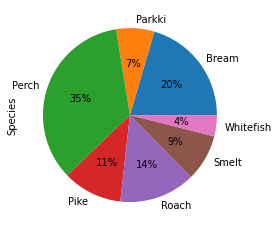

In [24]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

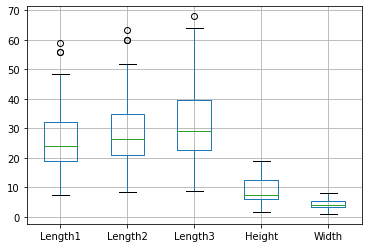

In [25]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [26]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    # our regressors
    "autoML": autoML(fitting_time=30, verbose=False),
}

## Check training performance

In [27]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [28]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [29]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

0.20
0.13
0.13
0.15
0.12


,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,581.638112,2.415595,0.043560,0.000520,0.000897
1,decisionTree,52.235846,0.061143,0.970613,0.001913,0.003731
2,linearRegression,102.737802,0.175759,0.929091,0.004636,0.002699
3,randomForestRegressor,40.173300,0.034536,0.985333,0.112342,0.008177
4,autoML,42.892284,0.043058,0.981807,30.146870,0.004787


### Preprocessing - One-hot encoding "Species"

In [30]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
95,170.0,21.5,23.5,25.0,6.2750,3.7250,0,0,1,0,0,0,0
80,85.0,17.8,19.6,20.8,5.1376,3.0368,0,0,1,0,0,0,0
76,70.0,15.7,17.4,18.5,4.5880,2.9415,0,0,1,0,0,0,0
109,514.0,30.5,32.8,34.0,10.0300,6.0180,0,0,1,0,0,0,0
45,160.0,20.5,22.5,25.3,7.0334,3.8203,0,0,0,0,1,0,0


In [31]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

0.15
0.17
0.19
0.13
0.14


,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,628.751999,2.862444,-0.084673,0.000945,0.001268
1,decisionTree,49.186985,0.054914,0.973103,0.002854,0.001982
2,linearRegression,76.345732,0.098992,0.956349,0.002084,0.002021
3,randomForestRegressor,41.733871,0.037986,0.984106,0.092354,0.007545
4,autoML,49.173239,0.060894,0.973712,30.183819,0.006250


### Preprocessing - One-hot encoding + standardization

In [32]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

0.23
0.18
0.20
0.15
0.15


,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,621.432030,2.600630,-0.175882,0.000987,0.001624
1,decisionTree,49.313692,0.056172,0.972577,0.002229,0.002129
2,linearRegression,76.345732,0.098992,0.956349,0.001804,0.001596
3,randomForestRegressor,41.342061,0.037436,0.984369,0.092509,0.007605
4,autoML,42.310514,0.039361,0.983557,30.113862,0.006234


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [33]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [34]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

0.16


,Name,MAE,RSE,CorrCoeff,TrainTime,TestTime
0,dummy,622.825283,5.348305,0.039728,0.000029,0.000029
1,decisionTree,53.893750,0.068485,0.966982,0.001876,0.001418
2,linearRegression,61.068549,0.046018,0.976870,0.001765,0.001034
3,randomForestRegressor,40.423146,0.029607,0.987319,0.123347,0.007214
4,autoML,41.994649,0.032365,0.985948,30.170161,0.008589
